In [1]:
import re
from rdkit import Chem
import sys
sys.path.append('../')

from LocalTemplate.template_extractor import *

rxns = {}
with open('../data/USPTO_480k/test.txt', 'r') as f:
    for i, line in enumerate(f.readlines()):
        rxns[i] = line.split(' ')[0]

In [2]:
import pandas as pd
from rdkit.Chem.AllChem import Draw
from pprint import pprint

i = 8
rxn=rxns[i]
r,p = rxn.split('>>')
results = extract_from_reaction(rxn)
pprint (results)

{'Charge_change': {1: 0, 2: 0},
 'H_change': {1: 0, 2: 0},
 'change_atoms': ['22', '32', '38'],
 'dimer_only': False,
 'edits': {'A': ([(17, 33)], [(22, 32)], [(1, 2)]),
           'B': ([(33, 25)], [(32, 38)], [(2, 3)]),
           'C': ([], [], []),
           'R': ([], [], [])},
 'intra_only': False,
 'necessary_reagent': ['ClCCl'],
 'products': '[CH3:1][c:2]1[cH:3][cH:4][c:5]([CH2:7][NH:8][c:9]2[n:10][c:11]3[cH:12][cH:13][cH:14][c:15]([NH:19][CH2:20][CH2:21][S:22]([CH3:23])=[O:32])[c:16]3[cH:17][cH:18]2)[o:6]1',
 'reactants': '[CH3:1][c:2]1[cH:3][cH:4][c:5]([CH2:7][NH:8][c:9]2[n:10][c:11]3[cH:12][cH:13][cH:14][c:15]([NH:19][CH2:20][CH2:21][S:22][CH3:23])[c:16]3[cH:17][cH:18]2)[o:6]1.OO[C:38](c1cccc(Cl)c1)=[O:32]',
 'reaction_id': 0,
 'reaction_smarts': '[A:1].[A:2]=[A:3]>>[A:1]=[A:2]',
 'replacement_dict': {'22': '1', '32': '2', '38': '3'}}


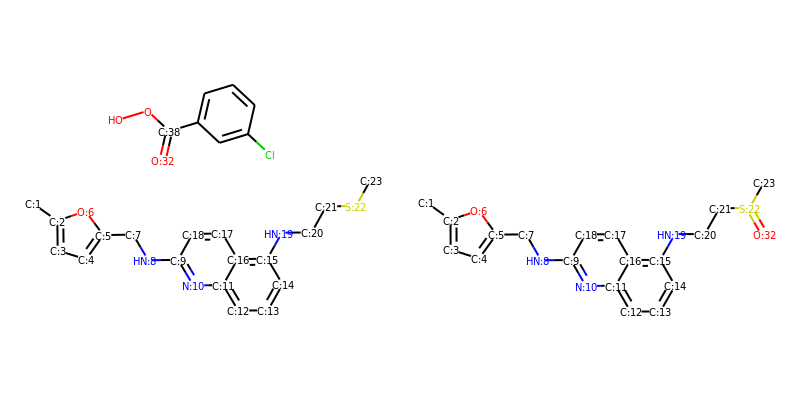

In [3]:
Draw.MolsToGridImage([Chem.MolFromSmiles(results['reactants']), Chem.MolFromSmiles(results['products'])],molsPerRow=2,subImgSize=(400, 400))

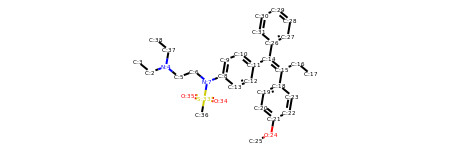

In [10]:
Chem.MolFromSmiles(p)

In [3]:
# rxn
rxn = 'CCOC(=O)Cl.N[C:13](=[S:15])[S-].O.S=C=S.[CH3:3][c:4]1[cH:5][cH:6][cH:7][c:8]([CH3:9])[c:10]1[NH2:11].[NH4+].[NH4+].[OH-]>>[CH3:3][c:4]1[cH:5][cH:6][cH:7][c:8]([CH3:9])[c:10]1[N:11]=[C:13]=[S:15]'
extract_from_reaction(rxn)

{'products': '[CH3:3][c:4]1[cH:5][cH:6][cH:7][c:8]([CH3:9])[c:10]1[N:11]=[C:13]=[S:15]',
 'reactants': '[C:13](=[S:15])([NH2:16])[S-:17].[CH3:3][c:4]1[cH:5][cH:6][cH:7][c:8]([CH3:9])[c:10]1[NH2:11]',
 'necessary_reagent': ['CCOC(=O)Cl',
  'O',
  'S=C=S',
  '[NH4+]',
  '[NH4+]',
  '[OH-]'],
 'reaction_smarts': '[A:1].[A:3]-[A:2]-[A:4]>>[A:1]=[A:2]',
 'intra_only': False,
 'dimer_only': False,
 'reaction_id': 0,
 'replacement_dict': {'11': '1', '13': '2', '17': '3', '16': '4'},
 'change_atoms': ['11', '13', '16', '17'],
 'edits': {'A': ([(12, 0)], [(11, 13)], [(1, 2)]),
  'B': ([(0, 2), (0, 3)], [(13, 16), (13, 17)], [(2, 4), (2, 3)]),
  'C': ([], [], []),
  'D': ([], [], [])},
 'H_change': {1: -2, 2: 0},
 'Charge_change': {1: 0, 2: 0}}

In [4]:
bonds = [(8, 13), (13, 19)]
used_atoms = set([atom for bond in bonds for atom in bond])
used_atoms

{8, 13, 19}

In [5]:
def prepare_template(smiles, template, pred_idxs, change_bond_only, intermolecule):
    if not change_bond_only:
        pred_idxs_inv = {v:k for k,v in pred_idxs.items()}
    else:
        pred_idxs_inv = {v:k+1 for k,v in enumerate(pred_idxs)}
    atom_nums = []
    new_smiles = []
    reduced_map = {}
    reactant_map = {}
    current_num = 0
    include_num = 0
    remap_num = 0
    for s in smiles.split('.'):
        m = Chem.MolFromSmiles(s)
        n = [pred_idxs_inv[atom.GetIdx()+current_num] for atom in m.GetAtoms() if atom.GetIdx()+current_num in pred_idxs_inv]
        if len(n) > 0:
            new_smiles.append(s)
            reactant_map[include_num] = {}
            for atom in m.GetAtoms():
                reduced_map[atom.GetIdx() + current_num] = atom.GetIdx() + remap_num
                reactant_map[include_num][atom.GetIdx()] = atom.GetIdx() + remap_num
            remap_num += m.GetNumAtoms()
            include_num += 1
        atom_nums.append(n)
        current_num += m.GetNumAtoms()
    if not change_bond_only:
        new_pred_idxs = {k:reduced_map[v] for k, v in pred_idxs.items()}
    else:
        new_pred_idxs = [reduced_map[v] for v in pred_idxs]
    temp_reactants = template.split('>>')[0].split('.')
    temp_nums = {temp: [int(r) for r in re.findall('\:([0-9]+)\]', temp)] for temp in temp_reactants}
    new_temp_reactants = []
    for nums in atom_nums:
        match_temp = False
        fragment_temp = []
        matched_nums = []
        for num in nums:
            if num in matched_nums:
                continue
            for temp, temp_num in temp_nums.items():
                if temp in fragment_temp:
                    continue
                if num in temp_num:
                    fragment_temp.append(temp)
                    matched_nums += temp_num
                    match_temp = True
        if match_temp == False:
            if intermolecule:
                return False
        else:
            new_temp_reactants.append('(%s)' % '.'.join(fragment_temp))
       
    return '.'.join(new_smiles), reactant_map, new_pred_idxs, '%s>>%s' % ('.'.join(new_temp_reactants), '(' + template.split('>>')[1] + ')')

In [5]:
smiles = '[c:2]1([Br:14])[c:3]([F:11])[cH:4][cH:5][c:6]2[cH:7][cH:8][s:9][c:10]12.CO[B:15](OC)[O:13][CH3:16].[Li]C(C)(C)C'
pred_idxs = {1: 16, 2: 0, 3: 17, 4: 13, 5: 1}
template = '[A;+0:1]-[A;+0:3].[A;+0:4]-[A;+0:2]-[A;+0:5]>>[A;+0:1]-[A;+0:2]'
prepare_template(smiles, template, pred_idxs, False, False)

('[c:2]1([Br:14])[c:3]([F:11])[cH:4][cH:5][c:6]2[cH:7][cH:8][s:9][c:10]12.CO[B:15](OC)[O:13][CH3:16]',
 {0: {0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6, 7: 7, 8: 8, 9: 9, 10: 10},
  1: {0: 11, 1: 12, 2: 13, 3: 14, 4: 15, 5: 16, 6: 17}},
 {1: 16, 2: 0, 3: 17, 4: 13, 5: 1},
 '([A;+0:4]-[A;+0:2]-[A;+0:5]).([A;+0:4]-[A;+0:2]-[A;+0:5].[A;+0:1]-[A;+0:3])>>([A;+0:1]-[A;+0:2])')

In [ ]:
print ('')

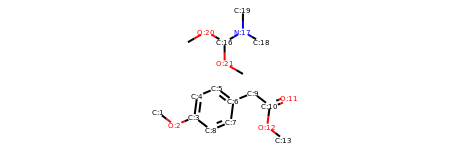

In [19]:
from rdkit import Chem

Chem.MolFromSmiles('C[O:20][CH:16]([N:17]([CH3:18])[CH3:19])[O:21]C.[CH3:1][O:2][c:3]1[cH:4][cH:5][c:6]([CH2:9][C:10](=[O:11])[O:12][CH3:13])[cH:7][cH:8]1')

In [5]:
len(['1', '3', '8', '6', '7', '29', '30', '31', '16', '5', '28', '12', '20', '2', '15', '14', '21', '17', '32', '33'])

20

In [6]:
edit_bonds = ([(15, 0), (14, 3), (0, 5), (3, 4), (3, 0), (13, 14), (15, 13)],
  [(14, 1), (13, 4), (1, 23), (4, 24), (4, 1), (12, 13), (14, 12)],
  [(1, 5), (3, 4), (5, 7), (4, 6), (4, 5), (2, 3), (1, 2)])

sort_bonds = {}
for b, bond in enumerate(sorted(edit_bonds[2])):
    idx = edit_bonds[2].index(bond)
    sort_bonds[b] = {'atom_idx': edit_bonds[0][idx], 'atom_map': edit_bonds[1][idx], 'temp_idx': bond}
    
sort_bonds

{0: {'atom_idx': (15, 13), 'atom_map': (14, 12), 'temp_idx': (1, 2)},
 1: {'atom_idx': (15, 0), 'atom_map': (14, 1), 'temp_idx': (1, 5)},
 2: {'atom_idx': (13, 14), 'atom_map': (12, 13), 'temp_idx': (2, 3)},
 3: {'atom_idx': (14, 3), 'atom_map': (13, 4), 'temp_idx': (3, 4)},
 4: {'atom_idx': (3, 0), 'atom_map': (4, 1), 'temp_idx': (4, 5)},
 5: {'atom_idx': (3, 4), 'atom_map': (4, 24), 'temp_idx': (4, 6)},
 6: {'atom_idx': (0, 5), 'atom_map': (1, 23), 'temp_idx': (5, 7)}}

In [7]:
import copy

def fix_edit_sites(reactant, template, edit_sites, H_change_data, H_change):
    new_edit_sites = copy.copy(edit_sites)
    new_H_change = copy.copy(H_change)
    N_sites = []
    mol = Chem.MolFromSmiles(reactant)
    for i, site in enumerate(edit_sites):
        atom = mol.GetAtomWithIdx(site)
        if atom.GetSymbol() == 'N':
            N_sites.append(i+1)
    print (N_sites)
    new_edit_sites[N_sites[0]-1] = edit_sites[N_sites[-1]-1]
    new_edit_sites[N_sites[-1]-1] = edit_sites[N_sites[0]-1]
    new_H_change[N_sites[0]] = H_change[N_sites[-1]]
    new_H_change[N_sites[-1]] = H_change[N_sites[0]]
    return new_edit_sites, new_H_change

In [13]:
edit_sites = [15, 13, 14, 3, 0, 5, 4]
template = '[A;+0:1]-[A;+0:2]=[A;+0:3].[A;+0:6]-[A;+0:4]-[A;+0:5]=[A;+0:7]>>[A;+0:1]1:[A;+0:2]:[A;+0:3]:[A;+0:4]:[A;+0:5]:1'
reactant = '[C:1]([CH2:2][CH3:3])([CH2:4][Br:24])=[O:23].[CH3:5][O:6][C:7](=[O:8])[c:9]1[cH:10][c:11]([C:12](=[NH:13])[NH2:14])[c:15]([CH:16]2[CH2:17][CH2:18][CH2:19]2)[cH:20][c:21]1[CH3:22]'
H_change_data = {5: 0, 4: -1, 3: 0, 2: 0, 1: -2}
H_change = {5: 0, 4: -1, 3: -1, 2: 0, 1: -1}

fix_edit_sites(reactant, template, edit_sites, H_change_data, H_change)

[1, 3]


([14, 13, 15, 3, 0, 5, 4], {5: 0, 4: -1, 3: -1, 2: 0, 1: -1})

In [45]:
def permutations(template):
    labels = re.findall('\:([0-9]+)\]', template)
    charges = re.findall('\;(.+?[0-9]+)\:', template)
    bonds = re.findall('\]([-=#:])\[', template)
    print (charges)
    if len(labels) == 1 or ''.join(bonds) != ''.join(bonds[::-1]) or ''.join(charges) != ''.join(charges[::-1]):
        return [labels]
    return [labels,  labels[::-1]]

template = '[A;-1:1]-[A;+1:2]'
permutations(template)

['-1', '+1']


[['1', '2']]

In [5]:


def inverse_template(template):
    def score_bonds(bonds):
        bond_dict = {b:str(i+1) for i,b in enumerate(['-', ':', '=', '#'])}
        return eval(''.join([bond_dict[b] for b in bonds]))
    bonds1 = re.findall('\]([-=#:])\[', template)
    bonds2 = bonds1[::-1]
    if score_bonds(bonds1) <= score_bonds(bonds2):
        return tempalte
    
    labels = re.findall(r'\[.*?]', template)[::-1]
    
    inv_template = labels[0]
    for i in range(len(bonds2)):
        inv_template += bonds2[i]
        inv_template += labels[i+1]
    return inv_template

inverse_template(template)

'[A;+0:19]-[A;+0:13]-[A;+0:1]=[A;+0:18]'

In [11]:
def prepare_template(smiles, template, pred_idxs, change_bond_only, intermolecule):
    
    if not change_bond_only:
        pred_idxs_inv = {v:k for k,v in pred_idxs.items()}
    else:
        pred_idxs_inv = {v:k+1 for k,v in enumerate(pred_idxs)}
    atom_nums = []
    current_num = 0
    for s in smiles.split('.'):
        m = Chem.MolFromSmiles(s)
        atom_nums.append([pred_idxs_inv[atom.GetIdx()+current_num] for atom in m.GetAtoms() if atom.GetIdx()+current_num in pred_idxs_inv])
        current_num += m.GetNumAtoms()
    temp_reactants = template.split('>>')[0].split('.')
    temp_nums = {temp: [int(r) for r in re.findall('\:([0-9]+)\]', temp)] for temp in temp_reactants}
    new_temp_reactants = []
    extra_num = 60
    for nums in atom_nums:
        match_temp = False
        fragment_temp = []
        matched_nums = []
        for num in nums:
            if num in matched_nums:
                continue
            for temp, temp_num in temp_nums.items():
                if temp in fragment_temp:
                    continue
                if num in temp_num:
                    fragment_temp.append(temp)
                    matched_nums += temp_num
                    match_temp = True
        if match_temp == False:
            if intermolecule:
                return False
            new_temp_reactants.append('([*:%s])' % extra_num)
            extra_num += 1
        else:
            new_temp_reactants.append('(%s)' % '.'.join(fragment_temp))
       
    return '%s>>%s' % ('.'.join(new_temp_reactants), template.split('>>')[1])

In [14]:
smiles = '[CH3:1][O:2][c:3]1[n:4][c:5]2[cH:6][cH:7][c:8]([CH:9]([OH:10])[c:11]3[cH:12][n:13][n:14][n:15]3[CH3:16])[cH:17][c:18]2[c:19]([Cl:20])[c:21]1[CH2:22][c:23]1[cH:24][cH:25][c:26]([C:27]([F:28])([F:29])[F:30])[cH:31][cH:32]1'

prepare_template(smiles, '[A;+0:1]-[A;+0:2]>>[A;+0:1]=[A;+0:2]', [9, 8], True, intermolecule = False)

'([A;+0:1]-[A;+0:2])>>[A;+0:1]=[A;+0:2]'